# Exploring the senegalese tax-benefit-system with OpenFisca

In [1]:
import matplotlib.pyplot as plt  # For graphics
%matplotlib inline
from openfisca_core import periods

from openfisca_senegal import CountryTaxBenefitSystem as SenegalTaxBenefitSystem  # The Senegalese tax-benefits system
from openfisca_senegal.scenarios import init_single_entity

## The concepts

### Tax Benefit System

In [2]:
tax_benefit_system = SenegalTaxBenefitSystem()

### Entities

In [3]:
tax_benefit_system.entities

### Variables 

In [4]:
tax_benefit_system.variables

{'age': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.age at 0x7f4f86e09910>,
 'date_naissance': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.date_naissance at 0x7f4fc3004dd0>,
 'est_celibataire': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.est_celibataire at 0x7f4f8c07aa90>,
 'est_divorce': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.est_divorce at 0x7f4fc2f8c450>,
 'est_marie': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.est_marie at 0x7f4f86e09950>,
 'est_veuf': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.est_veuf at 0x7f4f86e09e10>,
 'nombre_enfants': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.nombre_enfants at 0x7f4f86e09e90>,
 'statut_marital': <139979542009360_-4457291043182713956_caracteristiques_socio_demographiques.statut_marital at 0x7f4f86da0290>,
 'benefi

In [5]:
sorted(tax_benefit_system.variables.keys())

['age',
 'benefices_non_salarie',
 'conjoint_a_des_revenus',
 'date_naissance',
 'est_celibataire',
 'est_divorce',
 'est_marie',
 'est_veuf',
 'household_weight',
 'impot_avant_reduction_famille',
 'impot_revenus',
 'impots_indirects',
 'nombre_de_parts',
 'nombre_enfants',
 'pension_retraite',
 'person_weight',
 'reduction_impots_pour_charge_famille',
 'salaire',
 'statut_marital']

In [6]:
import inspect
for name, variable in sorted(tax_benefit_system.variables.items()):
    print(name)
    if not variable.is_input_variable():
        formula = variable.get_formula('2017')
        source_code = inspect.getsourcelines(formula)[0]
        print(''.join(source_code))
    print('')

age
    def formula(individu, period, parameters):
        date_naissance = individu('date_naissance', period)
        birth_year = date_naissance.astype('datetime64[Y]').astype(int) + 1970
        birth_month = date_naissance.astype('datetime64[M]').astype(int) % 12 + 1
        birth_day = (date_naissance - date_naissance.astype('datetime64[M]') + 1).astype(int)

        is_birthday_past = (
            (birth_month < period.start.month) + (birth_month == period.start.month) * (birth_day <= period.start.day)
            )
        # If the birthday is not passed this year, subtract one year
        return (period.start.year - birth_year) - where(is_birthday_past, 0, 1)


benefices_non_salarie

conjoint_a_des_revenus

date_naissance

est_celibataire
    def formula(individu, period):
        return individu('statut_marital', period) == TypesStatutMarital.celibataire


est_divorce
    def formula(individu, period):
        return individu('statut_marital', period) == TypesStatutMarital.v

### Parameters

In [7]:
print(tax_benefit_system.parameters)

nombre_de_parts:
  limite_max:
    2013-01-01: 5
  par_enfant:
    2013-01-01: 0.5
  repartition_marie_conjoint:
    2013-01-01: 0.5
  veuf_avec_enfant:
    2013-01-01: 0.5
prelevements_obligatoires:
  impots_directs:
    bareme_impot_progressif:
      brackets:
        - rate:
            2013-01-01: 0.0
          threshold:
            2013-01-01: 0.0
        - rate:
            2013-01-01: 0.2
          threshold:
            2013-01-01: 630000.0
        - rate:
            2013-01-01: 0.3
          threshold:
            2013-01-01: 1500000.0
        - rate:
            2013-01-01: 0.35
          threshold:
            2013-01-01: 4000000.0
        - rate:
            2013-01-01: 0.37
          threshold:
            2013-01-01: 8000000.0
        - rate:
            2013-01-01: 0.4
          threshold:
            2013-01-01: 13500000.0
    reductions_pour_charge_de_famille:
      max_1:
        2013-01-01: 0.0
      max_2:
        2013-01-01: 300000.0
      max_3:
        2013-01-

In [8]:
parameters = tax_benefit_system.parameters(2017)

In [9]:
parameters.prelevements_obligatoires.impots_directs.bareme_impot_progressif

  - threshold: 0.0
    rate: 0.0
  - threshold: 630000.0
    rate: 0.2
  - threshold: 1500000.0
    rate: 0.3
  - threshold: 4000000.0
    rate: 0.35
  - threshold: 8000000.0
    rate: 0.37
  - threshold: 13500000.0
    rate: 0.4

## A simple test case scenario

### Basics

In [10]:
scenario = tax_benefit_system.new_scenario()

In [11]:
init_single_entity(
    scenario,
    parent1 = {
        'salaire': 2800000,
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 1,
        },
    period = '2017',
    )

<openfisca_core.taxbenefitsystems.TaxBenefitSystem.new_scenario.<locals>.ScenarioAdapter at 0x7f4f86d83510>

In [12]:
simulation = scenario.new_simulation()

In [13]:
simulation.calculate('salaire', period = '2017')

array([2800000.], dtype=float32)

In [14]:
simulation.calculate('impot_revenus', period = '2017')

array([11700.], dtype=float32)

### Application: a simple function to compute the tax gain for having a child

In [15]:
def tax_gain(salaire = 0, est_marie = False, conjoint_a_des_revenus = False, nombre_enfants = 0):
    period = '2017'
    parent1_before = {
        'salaire': salaire,
        'est_marie': est_marie,
        'conjoint_a_des_revenus': conjoint_a_des_revenus,
        'nombre_enfants': nombre_enfants,
        }
    simulation_before = init_single_entity(
        tax_benefit_system.new_scenario(),
        parent1 = parent1_before,
        period = period,
        ).new_simulation()
    parent1_after = parent1_before.copy()
    parent1_after['nombre_enfants'] += 1
    simulation_after = init_single_entity(
        tax_benefit_system.new_scenario(),
        parent1 = parent1_after,
        period = period,
        ).new_simulation()
    difference = simulation_after.calculate('impot_revenus', period) - simulation_before.calculate('impot_revenus', period)
    return -difference
                                                                                            

In [16]:
tax_gain(salaire = 2800000)

array([100000.], dtype=float32)

In [17]:
tax_gain(salaire = 2800000, nombre_enfants = 2)

array([100000.], dtype=float32)

In [18]:
[tax_gain(salaire = 2800000, nombre_enfants = n) for n in range(8)]

[array([100000.], dtype=float32),
 array([100000.], dtype=float32),
 array([100000.], dtype=float32),
 array([11700.], dtype=float32),
 array([-0.], dtype=float32),
 array([-0.], dtype=float32),
 array([-0.], dtype=float32),
 array([-0.], dtype=float32)]

## More complex scenario: varying revenue 

### Basics

In [19]:
year = 2017
simulation = init_single_entity(
    tax_benefit_system.new_scenario(),
    parent1 = {
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 0,
        },
    period = year,
    axes = [[
        {
            'count': 100,
            'min': 0,
            'max': 15e6,
            'name': 'salaire',
            }
        ]],
    ).new_simulation()


salaire = simulation.calculate('salaire', period = year)
reduction_impots_pour_charge_famille = simulation.calculate('reduction_impots_pour_charge_famille', period = year)
impot_avant_reduction_famille = simulation.calculate('impot_avant_reduction_famille', period = year)
impot_revenus = simulation.calculate('impot_revenus', period = year)

Text(0.5, 1.0, '0 enfants')

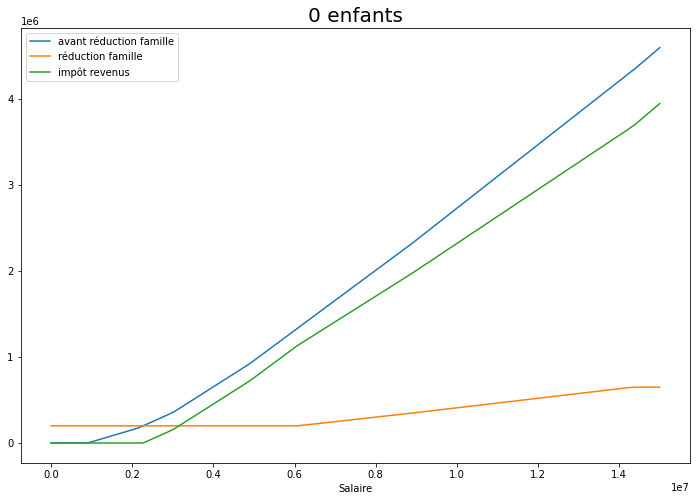

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(salaire, impot_avant_reduction_famille, label='avant réduction famille')
plt.plot(salaire, reduction_impots_pour_charge_famille, label='réduction famille')
plt.plot(salaire, impot_revenus, label='impôt revenus')
plt.xlabel('Salaire')
plt.legend()
plt.title('0 enfants', fontsize=20)

### Application: by how much the tax gain for having a child varies with revenue

In [21]:
def tax_gain_varying_revenue(max_salaire = 0, est_marie = False, conjoint_a_des_revenus = False, 
                             nombre_enfants = 0, count = 100):
    period = '2017'
    parent1_before = {
        'est_marie': est_marie,
        'conjoint_a_des_revenus': conjoint_a_des_revenus,
        'nombre_enfants': nombre_enfants,
        }
    axes = [[
            {
                'count': count,
                'min': 0,
                'max': max_salaire,
                'name': 'salaire',
                }
            ]]
    simulation_before = init_single_entity(
        tax_benefit_system.new_scenario(),
        parent1 = parent1_before,
        axes = axes,
        period = period,
        ).new_simulation()
    parent1_after = parent1_before.copy()
    parent1_after['nombre_enfants'] += 1
    simulation_after = init_single_entity(
        tax_benefit_system.new_scenario(),
        parent1 = parent1_after,
        axes = axes,
        period = period,
        ).new_simulation()
    difference = simulation_after.calculate('impot_revenus', period) - simulation_before.calculate('impot_revenus', period)
    salaire = simulation_after.calculate('salaire', period)
    return salaire, -difference
    

In [22]:
salaire, gain = tax_gain_varying_revenue(max_salaire=15e6, count = 1000)

Text(0.5, 1.0, 'Gain fiscal au 1er enfant')

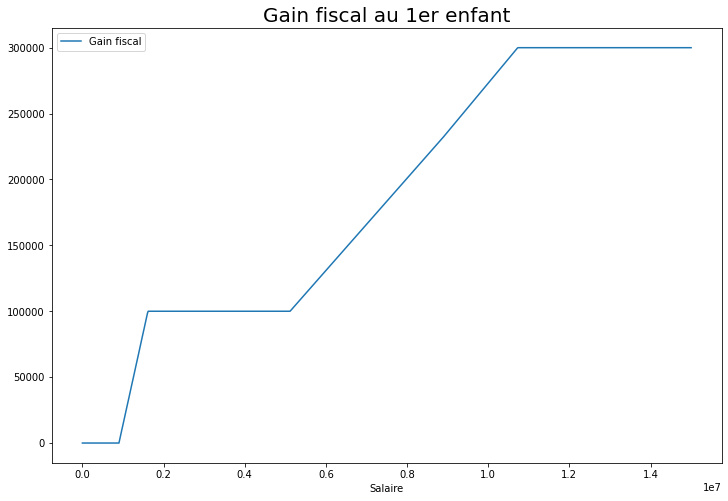

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(salaire, gain, label='Gain fiscal')
plt.xlabel('Salaire')
plt.legend()
plt.title('Gain fiscal au 1er enfant', fontsize=20)

#### Exercice: Write a loop to plot the gain for several children

Text(0.5, 1.0, "Gain fiscal selon le rang de l'enfant")

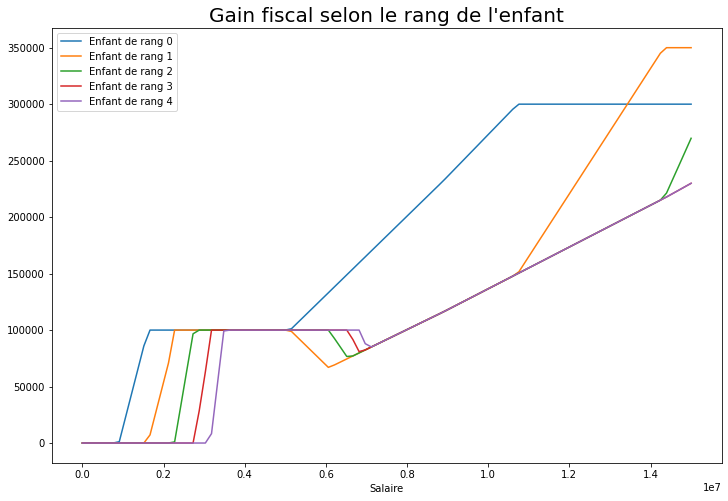

In [24]:
plt.figure(figsize=(12, 8))
for nombre_enfants in range(5):
    salaire, gain = tax_gain_varying_revenue(max_salaire=15e6, nombre_enfants = nombre_enfants)
    plt.plot(salaire, gain, label=u"Enfant de rang {}".format(nombre_enfants))

plt.xlabel('Salaire')
plt.legend()
plt.title(u"Gain fiscal selon le rang de l'enfant", fontsize=20)


## Tax rates

### Average tax rate

In [25]:
simulation = init_single_entity(
    tax_benefit_system.new_scenario(),
    parent1 = {
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 0,
        },
    period = year,
    axes = [[
        {
            'count': 100,
            'min': 0,
            'max': 18e6,
            'name': 'salaire',
            }
        ]],
    ).new_simulation()
salaire = simulation.calculate('salaire', period = year)
impot = simulation.calculate('impot_revenus', period = year)

Text(0.5, 0, 'Salaire')

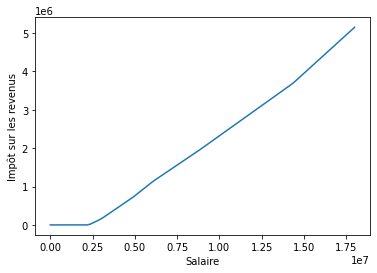

In [26]:
plt.plot(salaire, impot)
plt.ylabel(u"Impôt sur les revenus")
plt.xlabel(u"Salaire")

In [27]:
taux_moyen = impot / salaire  # Average tax rate

/home/benjello/.virtualenvs/ppd/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [28]:
taux_moyen = impot / (salaire * (salaire != 0) + (salaire == 0) )  

Text(0.5, 0, 'Salaire')

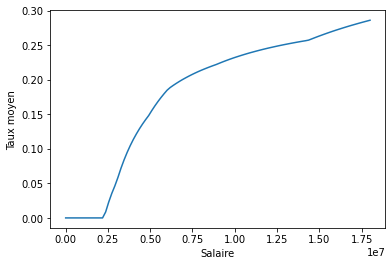

In [29]:
plt.plot(salaire, taux_moyen)
plt.ylabel("Taux moyen")
plt.xlabel("Salaire")

### Marginal tax rate

In [30]:
(impot[:-1] - impot[1:]) / (salaire[:-1] - salaire[1:])

array([-0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.11110011,  0.20954992,  0.21119992,
        0.20954992,  0.25410026,  0.30029988,  0.30029988,  0.30029988,
        0.3003003 ,  0.30029988,  0.29864988,  0.30029988,  0.3003003 ,
        0.3003003 ,  0.30277446,  0.34842536,  0.3503494 ,  0.35035035,
        0.35035035,  0.3503494 ,  0.35035035,  0.31623656,  0.29779696,
        0.2977978 ,  0.2977978 ,  0.29779696,  0.29616153,  0.29779696,
        0.2977978 ,  0.2977978 ,  0.29779696,  0.2977978 ,  0.29616153,
        0.29779696,  0.29779696,  0.2977978 ,  0.2986393 ,  0.31308505,
        0.3148148 ,  0.3148148 ,  0.31481308,  0.3148148 ,  0.3148148 ,
        0.31308505,  0.3148148 ,  0.31481308,  0.3148148 ,  0.3148148 ,
        0.31308505,  0.3148148 ,  0.3148148 ,  0.31481308,  0.3148148 ,
        0.3148148 ,  0.31308505,  0.3148148 ,  0.31481308,  0.31

In [31]:
taux_marginal =  (impot[:-1] - impot[1:]) / (salaire[:-1] - salaire[1:] )  # We avoid the first point

In [32]:
len(taux_marginal)

99

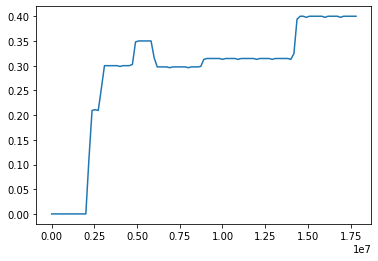

In [33]:
plt.plot(salaire[:-1], taux_marginal)

#### Exercice: how marginal and average tax rate compare at infinity

### Add a new variable and use dedicated functions

Add a disposable income variable to the tax-benefit-system

In [34]:
from openfisca_core.model_api import *
from openfisca_senegal.entities import Person

tax_benefit_system = SenegalTaxBenefitSystem()

class revenu_disponible(Variable):
    definition_period = YEAR
    entity = Person
    value_type = float

    def formula(person, period):
        salaire = person('salaire', period)
        pension_retraite = person('pension_retraite', period)
        impot_revenus = person('impot_revenus', period)
        return salaire + pension_retraite - impot_revenus


tax_benefit_system.add_variable(revenu_disponible)

In [35]:
simulation = init_single_entity(
    tax_benefit_system.new_scenario(),
    parent1 = {
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 0,
        },
    period = '2017',
    axes = [[
        {
            'count': 1000,
            'min': 0,
            'max': 50e6,
            'name': 'salaire',
            }
        ]],
    ).new_simulation()
salaire = simulation.calculate('salaire', period = year)
impot_revenus = simulation.calculate('impot_revenus', period = year)
revenu_disponible = simulation.calculate('revenu_disponible', period = year)

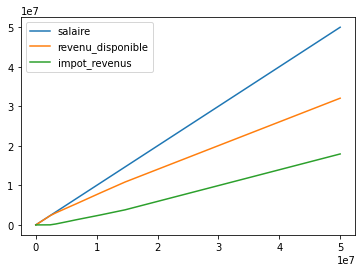

In [36]:
plt.plot(salaire, salaire, label = 'salaire')
plt.plot(salaire, revenu_disponible, label = 'revenu_disponible')
plt.plot(salaire, impot_revenus, label = 'impot_revenus')
plt.legend()

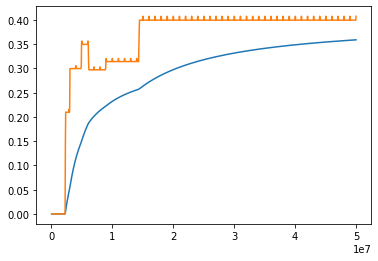

In [37]:
from openfisca_core.rates import average_rate, marginal_rate
plt.plot(salaire[1:], average_rate(revenu_disponible[1:], salaire[1:]))
plt.plot(salaire[1:], marginal_rate(revenu_disponible, salaire))

## Reforming the tax-benefit system

### Parametric reform

In [38]:
def modify_parameters(parameters):
    parameters.prelevements_obligatoires.impots_directs.bareme_impot_progressif[5].rate.update(period = period(year), value = .5)
    return parameters
    
class tax_the_rich(Reform):
    name = u"Tax last bracket at 50%"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [39]:
reformed_tax_benefit_system = tax_the_rich(tax_benefit_system)

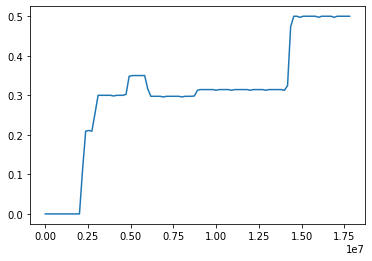

In [40]:
simulation = init_single_entity(
    reformed_tax_benefit_system.new_scenario(),
    parent1 = {
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 0,
        },
    period = year,
    axes = [[
        {
            'count': 100,
            'min': 0,
            'max': 18e6,
            'name': 'salaire',
            }
        ]],
    ).new_simulation()
salaire = simulation.calculate('salaire', period = year)
impot = simulation.calculate('impot_revenus', period = year)
taux_marginal =  (impot[:-1] - impot[1:]) / (salaire[:-1] - salaire[1:] )  # We avoid the first point
plt.plot(salaire[:-1], taux_marginal)

### Structural Reform

#### Exercice: add a an amount threshold under which no tax is due

In [41]:
seuil = 10000
tax_benefit_system = SenegalTaxBenefitSystem()
    
class impot_revenus(Variable):
    def formula(person, period):
        impot_avant_reduction_famille = person('impot_avant_reduction_famille', period)
        reduction_impots_pour_charge_famille = person('reduction_impots_pour_charge_famille', period)
        impot_apres_reduction_famille = impot_avant_reduction_famille - reduction_impots_pour_charge_famille
        impot_revenus = max_(0, impot_apres_reduction_famille)
        return impot_revenus * (impot_revenus > seuil)            

class revenu_disponible(Variable):
    definition_period = YEAR
    entity = Person
    value_type = float

    def formula(person, period):
        salaire = person('salaire', period)
        impot_revenus = person('impot_revenus', period)
        return salaire - impot_revenus

class structural_reform(Reform):
    name = u"Seuil de non-versement: {}".format(seuil)

    def apply(self):
        self.update_variable(impot_revenus)
        self.add_variable(revenu_disponible)

structurally_reformed_tax_benefit_system = structural_reform(tax_benefit_system)

In [42]:
def build_structural_reform(seuil = 10000):    
    tax_benefit_system = SenegalTaxBenefitSystem()
    
    class impot_revenus(Variable):
        def formula(individu, period):
            impot_avant_reduction_famille = individu('impot_avant_reduction_famille', period)
            reduction_impots_pour_charge_famille = individu('reduction_impots_pour_charge_famille', period)
            impot_apres_reduction_famille = impot_avant_reduction_famille - reduction_impots_pour_charge_famille
            impot_revenus = max_(0, impot_apres_reduction_famille)
            return impot_revenus * (impot_revenus > seuil)            

    class revenu_disponible(Variable):
        definition_period = YEAR
        entity = Person
        value_type = float

        def formula(person, period):
            salaire = person('salaire', period)
            impot_revenus = person('impot_revenus', period)
            return salaire - impot_revenus

    class structural_reform(Reform):
        name = u"Seuil de non-versement: {}".format(seuil)

        def apply(self):
            self.update_variable(impot_revenus)
            self.add_variable(revenu_disponible)

    return structural_reform(tax_benefit_system)

In [43]:
structural_reform = build_structural_reform(seuil = 100000)
simulation = init_single_entity(
    structural_reform.new_scenario(),
    parent1 = {
        'est_marie': True,
        'conjoint_a_des_revenus': False,
        'nombre_enfants': 0,
        },
    period = '2017',
    axes = [[
        {
            'count': 100,
            'min': 0,
            'max': 5e6,
            'name': 'salaire',
            }
        ]],
    ).new_simulation()
salaire = simulation.calculate('salaire', period = year)
impot_verse = simulation.calculate('impot_revenus', period = year)
revenu_disponible = simulation.calculate('revenu_disponible', period = year)

Text(0.5, 0, 'Salaire')

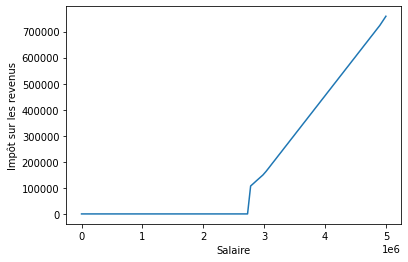

In [44]:
plt.plot(salaire, impot_verse)
plt.ylabel(u"Impôt sur les revenus")
plt.xlabel(u"Salaire")

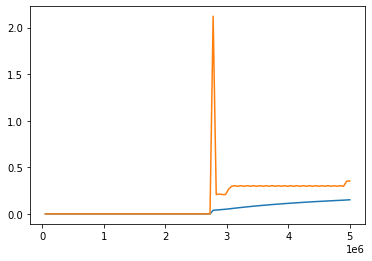

In [45]:
plt.plot(salaire[1:], average_rate(revenu_disponible[1:], salaire[1:]))
plt.plot(salaire[1:], marginal_rate(revenu_disponible, salaire))